In [1]:
import torch
import pandas as pd
device = 'cuda' if torch.cuda.is_available() else 'cpu'
import networkx as nx
import ast

In [42]:
from bertopic import BERTopic
from bertopic.representation import KeyBERTInspired
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
from nltk.corpus import stopwords
import nltk

# Download Spanish stopwords
nltk.download('stopwords')
spanish_stopwords = set(stopwords.words('spanish'))

# Combine English and Spanish stopwords
combined_stopwords = list(ENGLISH_STOP_WORDS.union(spanish_stopwords))

# Create a custom CountVectorizer
custom_vectorizer = CountVectorizer(stop_words=combined_stopwords)

# Initialize BERTopic
representation_model = KeyBERTInspired()
topic_model = BERTopic(language="multilingual", vectorizer_model=custom_vectorizer, representation_model=representation_model)


[nltk_data] Downloading package stopwords to
[nltk_data]     /home/bowenyi/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
en_data = pd.read_csv('en_sent.csv')
es_data = pd.read_csv('es_sent.csv')

In [3]:
def convert_format(field):
    return ast.literal_eval(field)

en_data['hashtags'] = en_data['hashtags'].apply(convert_format)
en_data['links'] = en_data['links'].apply(convert_format)
en_data['mentionedUsers'] = en_data['mentionedUsers'].apply(convert_format)

es_data['hashtags'] = es_data['hashtags'].apply(convert_format)
es_data['links'] = es_data['links'].apply(convert_format)
es_data['mentionedUsers'] = es_data['mentionedUsers'].apply(convert_format)


### 1. Detect bilingual posters

In [4]:
users_en = set(en_data['id_str'])  
users_es = set(es_data['id_str'])

bilingual_posters = users_en.intersection(users_es)

bilingual_posters = list(bilingual_posters)


In [6]:
print(f"{len(bilingual_posters)} bilingual posters")

13864 bilingual posters


In [7]:
def get_bilingual_tweets(bilingual_posters, en_data, es_data):
    """
    Extract tweets posted by bilingual users from English and Spanish datasets.

    Parameters:
    - bilingual_posters: List of user IDs who post in both English and Spanish.
    - en_data: DataFrame containing English tweets.
    - es_data: DataFrame containing Spanish tweets.

    Returns:
    - bilingual_en_tweets: DataFrame of English tweets by bilingual users.
    - bilingual_es_tweets: DataFrame of Spanish tweets by bilingual users.
    """
    bilingual_en_tweets = en_data[en_data['id_str'].isin(bilingual_posters)]
    bilingual_es_tweets = es_data[es_data['id_str'].isin(bilingual_posters)]

    return bilingual_en_tweets, bilingual_es_tweets


In [8]:
bilingual_en_tweets, bilingual_es_tweets = get_bilingual_tweets(bilingual_posters, en_data, es_data)


In [10]:
bilingual_en_tweets.shape

(85069, 17)

In [11]:
bilingual_es_tweets.shape

(63006, 17)

### 2. Topics & Engagement

In [16]:
def compare_engagement_metrics(en_tweets, es_tweets):
    metrics = ['likeCount', 'retweetCount', 'replyCount', 'quoteCount']
    en_avg = en_tweets[metrics].mean()
    es_avg = es_tweets[metrics].mean()

    print("English Engagement Metrics:\n", en_avg)
    print("Spanish Engagement Metrics:\n", es_avg)

    return en_avg, es_avg


In [17]:
compare_engagement_metrics(bilingual_en_tweets, bilingual_es_tweets)

English Engagement Metrics:
 likeCount       112.923709
retweetCount     37.643372
replyCount        7.137206
quoteCount        1.540197
dtype: float64
Spanish Engagement Metrics:
 likeCount       26.780640
retweetCount     4.599737
replyCount       1.528172
quoteCount       0.255531
dtype: float64


(likeCount       112.923709
 retweetCount     37.643372
 replyCount        7.137206
 quoteCount        1.540197
 dtype: float64,
 likeCount       26.780640
 retweetCount     4.599737
 replyCount       1.528172
 quoteCount       0.255531
 dtype: float64)

In [44]:
def analyze_topics_and_engagement(texts, tweet_data, top_n=8):
    """
    Analyzes popular topics and calculates average engagement stats for tweets associated with those topics.

    Parameters:
    - texts: List of tweet texts corresponding to the topic model.
    - tweet_data: DataFrame containing tweet metadata (e.g., 'text', 'likeCount', 'retweetCount', 'replyCount', 'quoteCount').
    - top_n: Number of top topics to analyze.
    """
    # Fit topics to texts
    topics, probs = topic_model.fit_transform(texts)

    # Create a DataFrame with topics and engagement stats
    topic_df = tweet_data.copy()
    topic_df['Topic'] = topics

    # Get top N topics by frequency
    topic_freq = topic_model.get_topic_freq().head(top_n + 1)  # Include outlier topic -1
    popular_topics = topic_freq[topic_freq['Topic'] != -1]['Topic'].tolist()  # Exclude -1

    # Calculate engagement stats for each topic
    topic_engagement = defaultdict(dict)
    for topic in popular_topics:
        topic_tweets = topic_df[topic_df['Topic'] == topic]
        avg_likes = topic_tweets['likeCount'].mean()
        avg_retweets = topic_tweets['retweetCount'].mean()
        avg_replies = topic_tweets['replyCount'].mean()
        avg_quotes = topic_tweets['quoteCount'].mean()

        topic_engagement[topic]['Average Likes'] = avg_likes
        topic_engagement[topic]['Average Retweets'] = avg_retweets
        topic_engagement[topic]['Average Replies'] = avg_replies
        topic_engagement[topic]['Average Quotes'] = avg_quotes

    # Print results
    print("\nTop Topics and Engagement Stats:")
    for topic in popular_topics:
        print(f"Topic {topic}: {', '.join([word for word, _ in topic_model.get_topic(topic)])} (Frequency: {topic_freq[topic_freq['Topic'] == topic]['Count'].iloc[0]})")
        print(f"  Average Likes: {topic_engagement[topic]['Average Likes']:.2f}")
        print(f"  Average Retweets: {topic_engagement[topic]['Average Retweets']:.2f}")
        print(f"  Average Replies: {topic_engagement[topic]['Average Replies']:.2f}")
        print(f"  Average Quotes: {topic_engagement[topic]['Average Quotes']:.2f}\n")


In [46]:
analyze_topics_and_engagement(bilingual_en_tweets['text'].tolist(), bilingual_en_tweets, top_n=10)


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 


Top Topics and Engagement Stats:
Topic 0: democrat, democratic, nominee, vote, democracy, election, candidate, obama, presidential, voters (Frequency: 3566)
  Average Likes: 526.37
  Average Retweets: 101.03
  Average Replies: 27.22
  Average Quotes: 6.58

Topic 1: shes, obama, elected, candidate, speech, katie, liar, jill, girl, lady (Frequency: 2857)
  Average Likes: 77.38
  Average Retweets: 26.46
  Average Replies: 2.30
  Average Quotes: 1.12

Topic 2: bidenswins, bidenhq, biden, joe, joebiden, bennyjohnson, bidenomics, ridin, chrisdjackson, harryjsisson (Frequency: 1610)
  Average Likes: 25.17
  Average Retweets: 17.41
  Average Replies: 2.04
  Average Quotes: 0.25

Topic 3: racists, racist, racism, racial, blacks, africans, minorities, african, segregation, black (Frequency: 1192)
  Average Likes: 112.31
  Average Retweets: 57.82
  Average Replies: 2.38
  Average Quotes: 0.49

Topic 4: dude, guy, man, fan, maga, lol, bryantejustin, shitting, met, face (Frequency: 1012)
  Average

In [47]:
analyze_topics_and_engagement(bilingual_es_tweets['text'].tolist(), bilingual_es_tweets, top_n=10)



Top Topics and Engagement Stats:
Topic 0: saamuellopez, maga, gusta, amigos, guapo, diria, rolotaaaaa, jiji, amo, carajo (Frequency: 1550)
  Average Likes: 18.61
  Average Retweets: 9.04
  Average Replies: 2.00
  Average Quotes: 0.85

Topic 1: bidenbestpresidentever, demócratas, democrats, demócrata, democratas, democrata, presidencial, candidato, candidatos, presidente (Frequency: 788)
  Average Likes: 6.32
  Average Retweets: 1.74
  Average Replies: 0.90
  Average Quotes: 0.14

Topic 2: defensa_israel, israel, israeli, israelies, فلسطين, israelí, israelíes, palestina, netanyahu, israelusaforeve (Frequency: 779)
  Average Likes: 8.81
  Average Retweets: 2.53
  Average Replies: 0.73
  Average Quotes: 0.10

Topic 3: liar, _johnnymaga, keneakers, therealthelmaj1, harrisonjaime, simonateba, hawleymo, jamiedupree, rbreich, magaincwarroom (Frequency: 639)
  Average Likes: 0.55
  Average Retweets: 0.02
  Average Replies: 0.10
  Average Quotes: 0.00

Topic 4: trump, presidente, dijo, expresi

### 3. Sentiment

In [50]:
avg_sent_en = bilingual_en_tweets.sentiment.mean()
avg_sent_en

1.0808755245741692

In [51]:
avg_sent_es = bilingual_es_tweets.sentiment.mean()
avg_sent_es

0.8436815541377012

In [72]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

def plot_sentiment_shift_2024(bilingual_en_tweets, bilingual_es_tweets):
    """
    Plots the shift of average sentiment over time for English and Spanish tweets, considering only tweets from 2024.
    The y-axis is labeled with 'Negative', 'Neutral', and 'Positive'.

    Parameters:
    - bilingual_en_tweets: DataFrame containing English tweets with 'epoch' and 'sentiment' columns.
    - bilingual_es_tweets: DataFrame containing Spanish tweets with 'epoch' and 'sentiment' columns.
    """
    # Convert epoch to datetime
    bilingual_en_tweets['Date'] = pd.to_datetime(bilingual_en_tweets['epoch'], unit='s')
    bilingual_es_tweets['Date'] = pd.to_datetime(bilingual_es_tweets['epoch'], unit='s')

    # Filter for tweets from the year 2024
    bilingual_en_tweets = bilingual_en_tweets[bilingual_en_tweets['Date'].dt.year == 2024]
    bilingual_es_tweets = bilingual_es_tweets[bilingual_es_tweets['Date'].dt.year == 2024]

    # Group by date and calculate average sentiment
    en_avg_sentiment = bilingual_en_tweets.groupby(bilingual_en_tweets['Date'].dt.date)['sentiment'].mean().reset_index(name='Average Sentiment')
    es_avg_sentiment = bilingual_es_tweets.groupby(bilingual_es_tweets['Date'].dt.date)['sentiment'].mean().reset_index(name='Average Sentiment')

    # Add a language column for comparison
    en_avg_sentiment['Language'] = 'English'
    es_avg_sentiment['Language'] = 'Spanish'

    # Combine datasets
    sentiment_data = pd.concat([en_avg_sentiment, es_avg_sentiment])

    # Plot using Seaborn
    plt.figure(figsize=(14, 8))
    sns.lineplot(data=sentiment_data, x='Date', y='Average Sentiment', hue='Language', marker='o', palette='tab10')
    
    # Customize y-axis
    plt.yticks([0, 1, 2], labels=['Negative', 'Neutral', 'Positive'])
    plt.ylim(-0.1, 2.1)  # Add some padding around the y-axis limits
    
    # Add labels and title
    # plt.title('Sentiment Shift Over Time', fontsize=16)
    plt.xlabel('Date', fontsize=14)
    plt.ylabel('Average Sentiment', fontsize=14)
    plt.legend(title='Language')
    plt.grid(True)

    # Show plot
    plt.savefig('sentiment.png', bbox_inches='tight', dpi=300)
    plt.show()


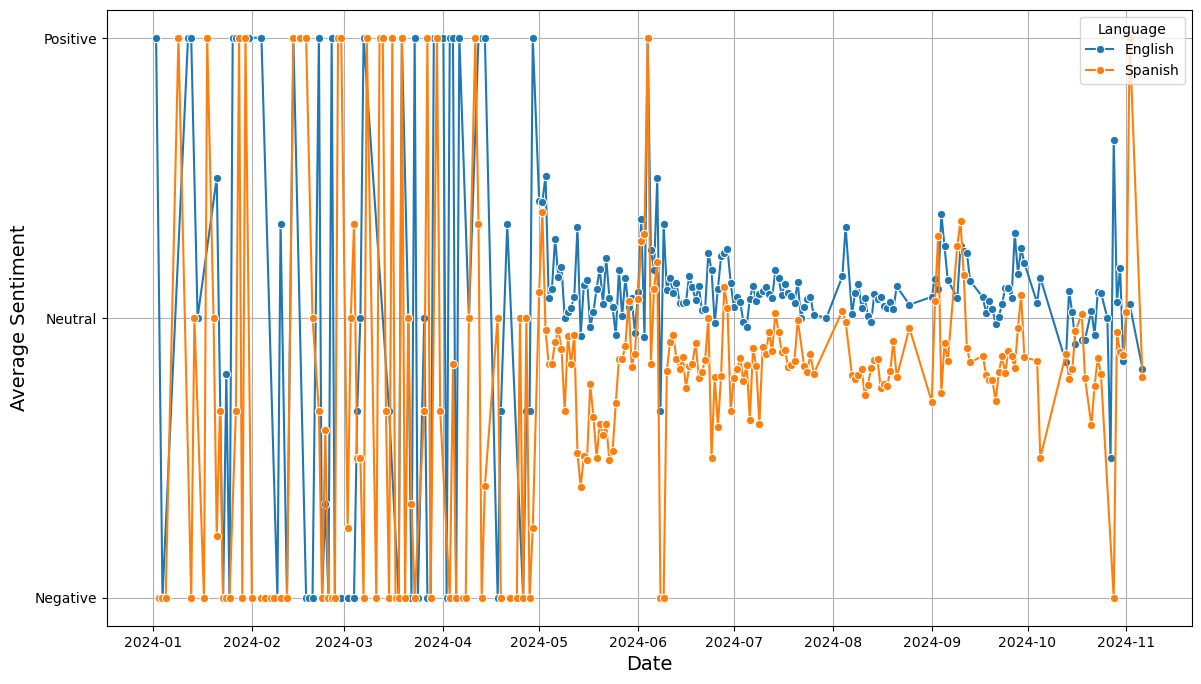

In [73]:
plot_sentiment_shift_2024(bilingual_en_tweets, bilingual_es_tweets)


### 4. Top tags and domains

In [81]:
from collections import Counter
en_exclude_domains = ["youtu.be", "x.com", "youtube.com", "dlvr.it", "trib.al", "ift.tt", "tiktok.com", "bit.ly", "yahoo.com"]
es_exclude_domains = ["dlvr.it", "youtu.be", 'twitter.com', "youtube.com", "x.com", "bit.ly", 'zurl.co', "tiktok.com", 'instagram.com', "buff.ly", "ift.tt", "ow.ly", "tinyurl.com", "short.gy", "trib.al", "acortar.link", "uni.vi"]
import tldextract

def extract_base_domain(url):
    extracted = tldextract.extract(url)
    return f"{extracted.domain}.{extracted.suffix}"
    
def get_top_domains(data, exclude_domains, top_n=5):
    """
    Returns the top N most common domains and their frequencies.

    Parameters:
    - data: DataFrame containing the raw tweet data with 'links'.
    - exclude_domains: List of domains to exclude from counting.
    - top_n: Number of top domains to return.

    Returns:
    - List of tuples with the top N domains and their frequencies.
    """
    domains = []

    # Extract domains from the 'links' column
    for _, row in data.iterrows():
        urls = row.get('links', [])
        if isinstance(urls, list):
            for url in urls:
                if isinstance(url, dict) and 'expanded_url' in url and len(url['expanded_url']) > 0:
                    base_domain = extract_base_domain(url['expanded_url'])
                    if base_domain not in exclude_domains:
                        domains.append(base_domain)

    return Counter(domains).most_common(top_n)


In [77]:
top_en_domains = get_top_domains(bilingual_en_tweets, en_exclude_domains, top_n=5)
print("Top Domains in English Tweets:", top_en_domains)


Top Domains in English Tweets: [('breitbart.com', 238), ('foxnews.com', 232), ('newsbreak.com', 119), ('rawstory.com', 116), ('rumble.com', 110)]


In [82]:
top_es_domains = get_top_domains(bilingual_es_tweets, es_exclude_domains, top_n=5)
print("Top Domains in Spanish Tweets:", top_es_domains)


Top Domains in Spanish Tweets: [('voz.us', 315), ('clarin.com', 136), ('cnn.com', 90), ('inmigracionyvisas.com', 81), ('rt.com', 66)]


In [ ]:
def get_top_tags(data, top_n=5):
    """
    Returns the top N most common tags and their frequencies.

    Parameters:
    - data: DataFrame containing the raw tweet data with 'hashtags'.
    - top_n: Number of top tags to return.

    Returns:
    - List of tuples with the top N tags and their frequencies.
    """
    tags = []

    # Extract hashtags from the 'hashtags' column
    for _, row in data.iterrows():
        hashtags = row.get('hashtags', [])
        if isinstance(hashtags, list):
            for tag in hashtags:
                if 'text' in tag:
                    tags.append(tag['text'].lower())

    return Counter(tags).most_common(top_n)


In [84]:
top_en_tags = get_top_tags(bilingual_en_tweets, top_n=5)
print("Top Tags in English Tweets:", top_en_tags)


Top Tags in English Tweets: [('trump2024', 1331), ('maga', 1109), ('trump', 345), ('biden', 301), ('bidenharris2024', 116)]


In [85]:
top_es_tags = get_top_tags(bilingual_es_tweets, top_n=5)
print("Top Tags in Spanish Tweets:", top_es_tags)


Top Tags in Spanish Tweets: [('trump2024', 970), ('maga', 540), ('maripily', 382), ('maripilyrivera', 361), ('biden', 246)]


### 5. Overlap with identified IO drivers

In [86]:
en_network = pd.read_csv("en_fused_nothing.csv")
es_network = pd.read_csv("es_low_weight_filtered.csv")


In [87]:
top_3_percent_en = int(en_network.shape[0] * 0.03)
top_5_percent_es = int(es_network.shape[0] * 0.05)

# Get the top 5% nodes by eigencentrality
io_drivers_en = en_network.sort_values(by='eigencentrality', ascending=False).head(top_3_percent_en)
io_drivers_es = es_network.sort_values(by='eigencentrality', ascending=False).head(top_5_percent_es)


In [91]:
# Convert lists to sets for efficient intersection
en_driver_ids = set(io_drivers_en['Id'].to_list())
es_driver_ids = set(io_drivers_es['Id'].to_list())
bilingual_ids = set(bilingual_posters)

# Find IO drivers who are also bilingual posters
bilingual_en_drivers = en_driver_ids.intersection(bilingual_ids)
bilingual_es_drivers = es_driver_ids.intersection(bilingual_ids)

# Print results
print(f"Number of English IO drivers who are bilingual: {len(bilingual_en_drivers)}")
print(f"Number of Spanish IO drivers who are bilingual: {len(bilingual_es_drivers)}")

print("\nEnglish IO Drivers who are bilingual:", bilingual_en_drivers)
print("\nSpanish IO Drivers who are bilingual:", bilingual_es_drivers)


Number of English IO drivers who are bilingual: 53
Number of Spanish IO drivers who are bilingual: 0

English IO Drivers who are bilingual: {"'176619668'", "'234789656'", "'1523440939594928128'", "'4249328180'", "'4861982862'", "'1323861935385800705'", "'1917731'", "'21651982'", "'1574732175647412224'", "'55060090'", "'1105275091267579905'", "'896731633704947712'", "'2494257098'", "'1591076408817848320'", "'234840640'", "'1628158010731433985'", "'1722458138081648640'", "'1518778017669033984'", "'1343367645748473856'", "'1703696108759941120'", "'390127278'", "'1080574175398506511'", "'14662354'", "'1729857551053750272'", "'7998482'", "'1669454273120198656'", "'1518736523239337990'", "'1704277755423039488'", "'1798830863720800256'", "'19788537'", "'82689705'", "'1607179494267453440'", "'1463720040717602816'", "'1760087969963139072'", "'1704277567170375680'", "'1617273338245615617'", "'1565826175498391558'", "'901191623144390656'", "'181451403'", "'1518684152211537920'", "'29465136'", "'3